In [54]:
import os
from pathlib import Path

for p in ["data", "data/raw", "data/clean", "output", "output/plots", "report"]:
    Path(p).mkdir(parents=True, exist_ok=True)



In [55]:
import requests

CENSUS_INCOME_URL = "https://example.com/census_income_table.xls"   # <- change this
FRED_API_KEY = "YOUR_FRED_KEY_HERE"  # <- change this or skip cell
RAW_DIR = Path("data/raw")

def download_file(url, dest):
    r = requests.get(url)
    r.raise_for_status()
    dest.write_bytes(r.content)
    print("saved", dest)

In [56]:
import pandas as pd
from pathlib import Path
import re

raw = pd.read_csv("data/raw/incomedata.csv", header=None)

#header for some of the rows
header_top = raw.iloc[2]
header_bottom = raw.iloc[3]

combined_cols = []
for top, bottom in zip(header_top, header_bottom):
    top = "" if pd.isna(top) else str(top).strip()
    bottom = "" if pd.isna(bottom) else str(bottom).strip()
    if top and bottom:
        combined_cols.append(f"{top} {bottom}")
    elif top:
        combined_cols.append(top)
    else:
        combined_cols.append(bottom)

# find the all race data
all_races_mask = raw[0].astype(str).str.strip().eq("ALL RACES")
if not all_races_mask.any():
    raise ValueError("Couldn't find 'ALL RACES' in column 0.")
start_idx = raw[all_races_mask].index[0] + 1 
rows = []
for i in range(start_idx, len(raw)):
    val = str(raw.iloc[i, 0]).strip()
    #stop the forloop if another group leader is detected
    if val in ["White", "Black", "Asian", "Hispanic origin (any race)", "Hispanic origin"]:
        break
    # keep rows that have a four digit yr 
    if re.search(r"\d{4}", val):
        rows.append(i)

data = raw.iloc[rows].copy()
data.columns = combined_cols

# detect year and median columns
year_col = next((c for c in data.columns if "Origin of householder" in c or "year" in c.lower()), None)
income_col = next((c for c in data.columns if "Median income" in c and "dollars" in c), None)

if not year_col or not income_col:
    raise ValueError(f"Couldn't detect columns. year_col={year_col}, income_col={income_col}")

df = data[[year_col, income_col]].rename(columns={
    year_col: "year",
    income_col: "median_income_nominal"
})

#clean year
df["year"] = df["year"].astype(str).str.extract(r"(\d{4})")
df = df[df["year"].notna()]
df["year"] = df["year"].astype(int)

# clean income
df["median_income_nominal"] = (
    df["median_income_nominal"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

df = df.sort_values("year").reset_index(drop=True)

Path("data/clean").mkdir(parents=True, exist_ok=True)
df.to_csv("data/clean/income_clean.csv", index=False)

df


,year,median_income_nominal
0,1967,33230.0
1,1967,57230.0
2,1967,54880.0
3,1968,NaN
4,1968,59580.0
...,...,...
485,2024,79800.0
486,2024,70950.0
487,2024,56290.0
488,2024,88010.0


In [57]:
import pandas as pd
import requests
from pathlib import Path

# api key stuff info
FRED_API_KEY = "18d62bb20c7238fec4b5145abcbb9af7"   
SERIES_ID = "ASPUS"  # Average Sales Price of Houses Sold for the U.S.
OUT_PATH = Path("data/clean/housing_clean.csv")

# getting the data from fred
url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id": SERIES_ID,
    "api_key": FRED_API_KEY,
    "file_type": "json",
    'observation_start' : "1963-01-01"
}

response = requests.get(url, params=params)
response.raise_for_status()

data = response.json()["observations"]
df = pd.DataFrame(data)

# clean + convert
df["value"] = pd.to_numeric(df["value"], errors="coerce")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year

# aggregate 
housing_yearly = df.groupby("year", as_index=False)["value"].mean()
housing_yearly = housing_yearly.rename(columns={"value": "avg_sales_price"})


Path("data/clean").mkdir(parents=True, exist_ok=True)
housing_yearly.to_csv(OUT_PATH, index=False)



In [58]:
import pandas as pd
import requests
from pathlib import Path
# pulling in the cpi data so that it can 
FRED_API_KEY = "18d62bb20c7238fec4b5145abcbb9af7"
CPI_SERIES = "CPIAUCSL"
OUT_PATH = Path("data/clean/cpi_clean.csv")

url = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id": CPI_SERIES,
    "api_key": FRED_API_KEY,
    "file_type": "json",
    "observation_start": "1960-01-01"
}

resp = requests.get(url, params=params)
resp.raise_for_status()
obs = resp.json()["observations"]

cpi = pd.DataFrame(obs)
cpi["value"] = pd.to_numeric(cpi["value"], errors="coerce")
cpi["date"] = pd.to_datetime(cpi["date"])
cpi["year"] = cpi["date"].dt.year

# find the average consumer price index so that the data can be realized towards the present value
cpi_yearly = cpi.groupby("year", as_index=False)["value"].mean().rename(columns={"value": "cpi"})

Path("data/clean").mkdir(parents=True, exist_ok=True)
cpi_yearly.to_csv(OUT_PATH, index=False)




In [59]:
import pandas as pd

income = pd.read_csv("data/clean/income_clean.csv")
housing = pd.read_csv("data/clean/housing_clean.csv")
cpi = pd.read_csv("data/clean/cpi_clean.csv")

#taking the most recent year as the base for the cpi calculations
base_year = cpi["year"].max()
base_cpi = cpi.loc[cpi["year"] == base_year, "cpi"].iloc[0]

# taking the current consumer price index and then dividing it to get the base factor
cpi["inflation_factor_to_base"] = base_cpi / cpi["cpi"]

# merge all 3
merged = housing.merge(income, on="year", how="inner")
merged = merged.merge(cpi[["year", "inflation_factor_to_base"]], on="year", how="left")

# inflation adjustments made 
merged["median_income_real"] = merged["median_income_nominal"] * merged["inflation_factor_to_base"]
merged["avg_sales_price_real"] = merged["avg_sales_price"] * merged["inflation_factor_to_base"]

merged = merged.sort_values("year")

merged.to_csv("data/clean/merged.csv", index=False)
merged.tail()


,year,avg_sales_price,median_income_nominal,inflation_factor_to_base,median_income_real,avg_sales_price_real
485,2024,507875.0,79800.0,1.023894,81706.770475,520010.351566
486,2024,507875.0,70950.0,1.023894,72645.305328,520010.351566
487,2024,507875.0,56290.0,1.023894,57635.013910,520010.351566
488,2024,507875.0,88010.0,1.023894,90112.943227,520010.351566
489,2024,507875.0,83730.0,1.023894,85730.675337,520010.351566


In [ ]:
import pandas as pd

merged = pd.read_csv("data/clean/merged.csv").sort_values("year")

# affordability ratios 
merged["afford_ratio_nominal"] = merged["avg_sales_price"] / merged["median_income_nominal"]
merged["afford_ratio_real"] = merged["avg_sales_price_real"] / merged["median_income_real"]

# YoY changes
merged["pct_change_income_real"] = merged["median_income_real"].pct_change() * 100
merged["pct_change_housing_real"] = merged["avg_sales_price_real"].pct_change() * 100

# gap = housing growing faster than income
merged["growth_gap_pp"] = merged["pct_change_housing_real"] - merged["pct_change_income_real"]

merged.to_csv("data/clean/merged_affordability.csv", index=False)
merged.tail(10)


✅ saved affordability metrics


C:\Users\eshan\AppData\Local\Temp\ipykernel_32440\1289909405.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  merged["pct_change_income_real"] = merged["median_income_real"].pct_change() * 100


,year,avg_sales_price,median_income_nominal,inflation_factor_to_base,median_income_real,avg_sales_price_real,afford_ratio_nominal,afford_ratio_real,pct_change_income_real,pct_change_housing_real,growth_gap_pp
480,2024,507875.0,56020.0,1.023894,57358.562431,520010.351566,9.065959,9.065959,-39.457473,0.0,39.457473
481,2024,507875.0,62760.0,1.023894,64259.610464,520010.351566,8.092336,8.092336,12.031417,0.0,-12.031417
482,2024,507875.0,121700.0,1.023894,124607.944446,520010.351566,4.173172,4.173172,93.913321,0.0,-93.913321
483,2024,507875.0,120900.0,1.023894,123788.828953,520010.351566,4.200786,4.200786,-0.657354,0.0,0.657354
484,2024,507875.0,59050.0,1.023894,60460.962363,520010.351566,8.600762,8.600762,-51.157982,0.0,51.157982
485,2024,507875.0,79800.0,1.023894,81706.770475,520010.351566,6.364348,6.364348,35.139712,0.0,-35.139712
486,2024,507875.0,70950.0,1.023894,72645.305328,520010.351566,7.158210,7.158210,-11.090226,0.0,11.090226
487,2024,507875.0,56290.0,1.023894,57635.013910,520010.351566,9.022473,9.022473,-20.662438,0.0,20.662438
488,2024,507875.0,88010.0,1.023894,90112.943227,520010.351566,5.770651,5.770651,56.351039,0.0,-56.351039
489,2024,507875.0,83730.0,1.023894,85730.675337,520010.351566,6.065628,6.065628,-4.863084,0.0,4.863084


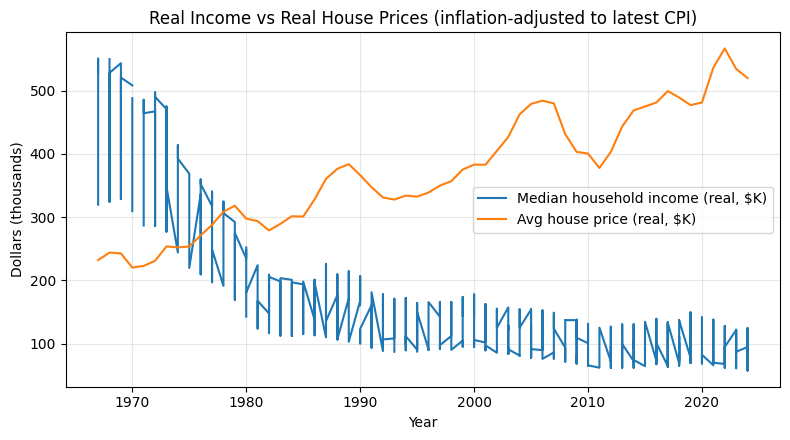

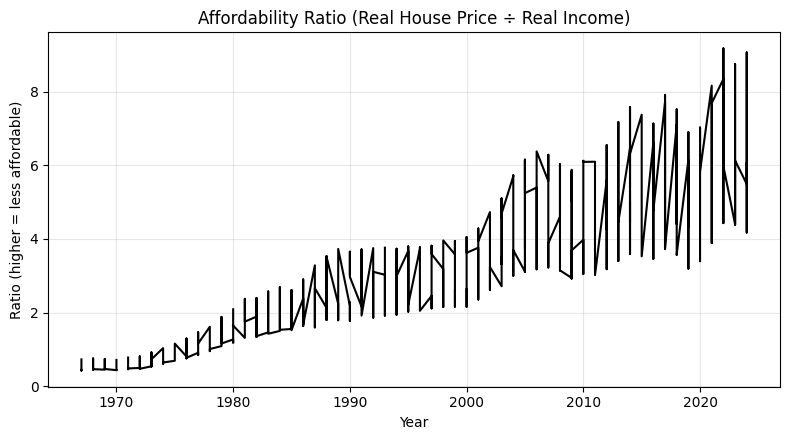

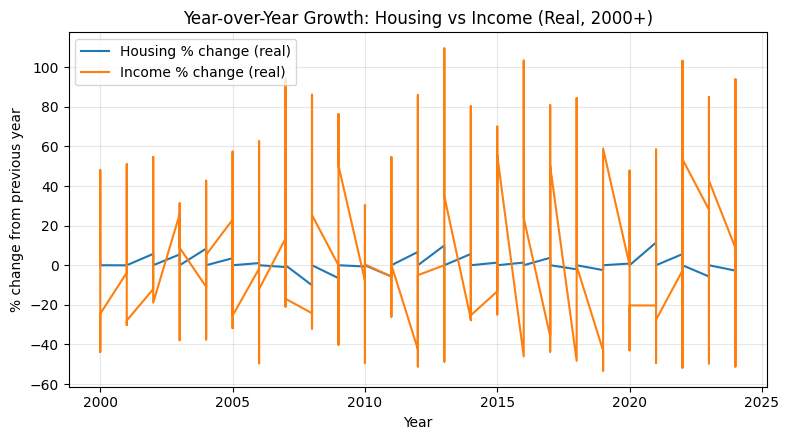

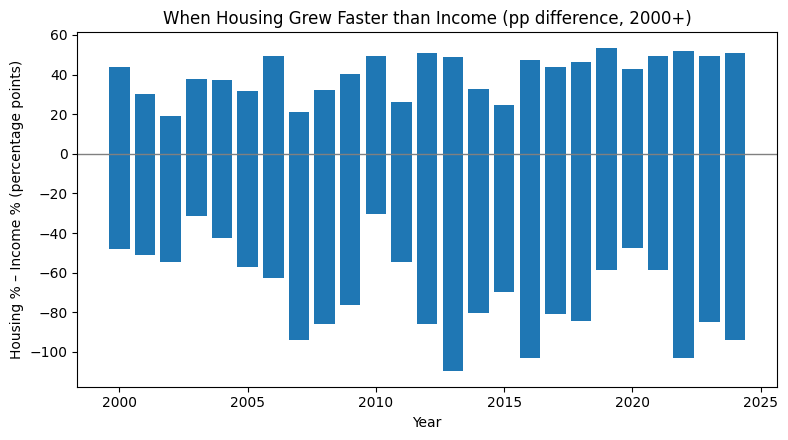

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv("data/clean/merged_affordability.csv")
Path("output/plots").mkdir(parents=True, exist_ok=True)

# make sure year is sorted
df = df.sort_values("year")

# 1) LEVELS (real): income vs house price
plt.figure(figsize=(8, 4.5))
plt.plot(df["year"], df["median_income_real"] / 1000, label="Median household income (real, $K)")
plt.plot(df["year"], df["avg_sales_price_real"] / 1000, label="Avg house price (real, $K)")
plt.title("Real Income vs Real House Prices (inflation-adjusted to latest CPI)")
plt.xlabel("Year")
plt.ylabel("Dollars (thousands)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("output/plots/01_income_vs_price_real.png", dpi=300)
plt.show()

# 2) AFFORDABILITY RATIO over time
plt.figure(figsize=(8, 4.5))
plt.plot(df["year"], df["afford_ratio_real"], color="black")
plt.title("Affordability Ratio (Real House Price ÷ Real Income)")
plt.xlabel("Year")
plt.ylabel("Ratio (higher = less affordable)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("output/plots/02_affordability_ratio.png", dpi=300)
plt.show()

# 3) YOY growth – show only recent years so it isn’t noisy
recent = df[df["year"] >= 2000].copy()

plt.figure(figsize=(8, 4.5))
plt.plot(recent["year"], recent["pct_change_housing_real"], label="Housing % change (real)")
plt.plot(recent["year"], recent["pct_change_income_real"], label="Income % change (real)")
plt.title("Year-over-Year Growth: Housing vs Income (Real, 2000+)")
plt.xlabel("Year")
plt.ylabel("% change from previous year")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("output/plots/03_yoy_growth_recent.png", dpi=300)
plt.show()

# 4) GAP (housing – income) to show years it got worse fast
plt.figure(figsize=(8, 4.5))
plt.bar(recent["year"], recent["growth_gap_pp"])
plt.axhline(0, color="gray", linewidth=1)
plt.title("When Housing Grew Faster than Income (pp difference, 2000+)")
plt.xlabel("Year")
plt.ylabel("Housing % – Income % (percentage points)")
plt.tight_layout()
plt.savefig("output/plots/04_growth_gap_recent.png", dpi=300)
plt.show()



C:\Users\eshan\AppData\Local\Temp\ipykernel_32440\3441444722.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  income_idx = df_recent["median_income_real"] / float(base["median_income_real"]) * 100
C:\Users\eshan\AppData\Local\Temp\ipykernel_32440\3441444722.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_idx  = df_recent["avg_sales_price_real"] / float(base["avg_sales_price_real"]) * 100


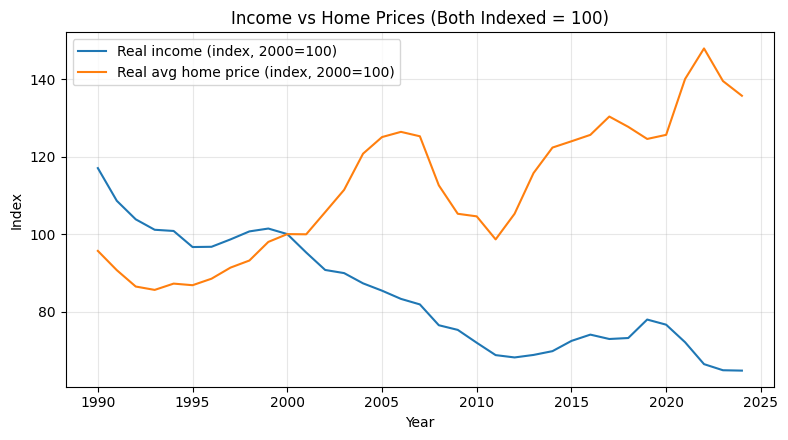

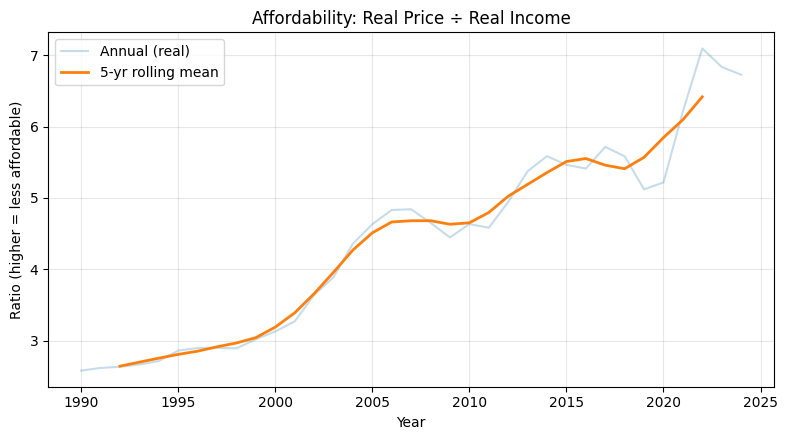

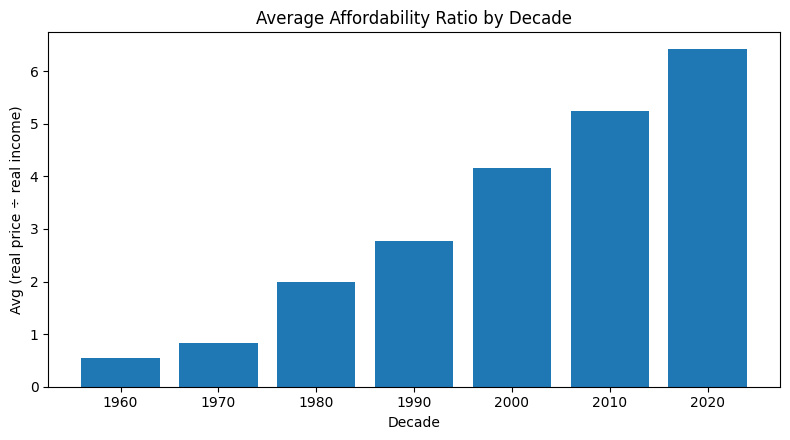

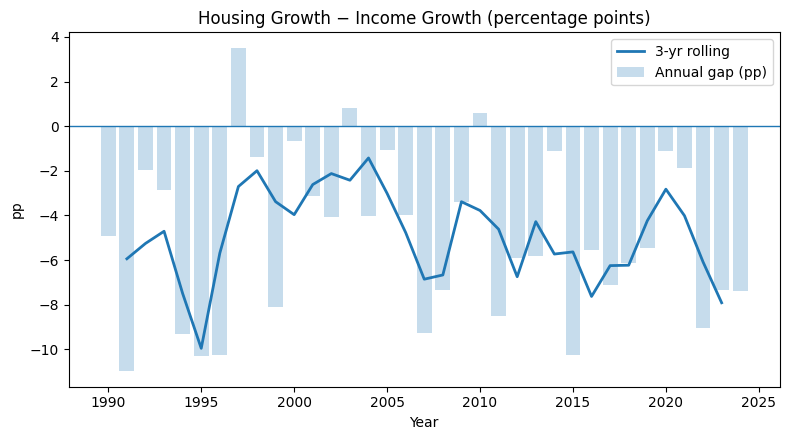

: 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

df = pd.read_csv("data/clean/merged_affordability.csv")
num_cols = ["median_income_real","avg_sales_price_real","afford_ratio_real","pct_change_income_real","pct_change_housing_real","growth_gap_pp"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
df = (df.groupby("year", as_index=False)[num_cols].mean().sort_values("year").dropna(subset=["median_income_real","avg_sales_price_real","afford_ratio_real"]))
df_recent = df[df["year"] >= 1990].copy()

base_year = 2000
base = df_recent.loc[df_recent["year"]==base_year]
if base.empty:
    base_year = int(df_recent["year"].iloc[0])
    base = df_recent.iloc[[0]]

income_idx = df_recent["median_income_real"] / float(base["median_income_real"]) * 100
price_idx  = df_recent["avg_sales_price_real"] / float(base["avg_sales_price_real"]) * 100

plt.figure(figsize=(8,4.5))
plt.plot(df_recent["year"], income_idx, label=f"Real income (index, {base_year}=100)")
plt.plot(df_recent["year"], price_idx,  label=f"Real avg home price (index, {base_year}=100)")
plt.title("Income vs Home Prices (Both Indexed = 100)")
plt.xlabel("Year"); plt.ylabel("Index")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("output/plots/A_indexed_levels.png", dpi=300); plt.show()

df_recent["afford_ratio_roll5"] = df_recent["afford_ratio_real"].rolling(5, center=True).mean()
plt.figure(figsize=(8,4.5))
plt.plot(df_recent["year"], df_recent["afford_ratio_real"], alpha=0.25, label="Annual (real)")
plt.plot(df_recent["year"], df_recent["afford_ratio_roll5"], linewidth=2, label="5-yr rolling mean")
plt.title("Affordability: Real Price ÷ Real Income")
plt.xlabel("Year"); plt.ylabel("Ratio (higher = less affordable)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig("output/plots/B_affordability_smoothed.png", dpi=300); plt.show()

dec = (df.assign(decade=(df["year"]//10)*10).groupby("decade", as_index=False)["afford_ratio_real"].mean())
plt.figure(figsize=(8,4.5))
plt.bar(dec["decade"].astype(str), dec["afford_ratio_real"])
plt.title("Average Affordability Ratio by Decade")
plt.xlabel("Decade"); plt.ylabel("Avg (real price ÷ real income)")
plt.tight_layout()
plt.savefig("output/plots/C_affordability_by_decade.png", dpi=300); plt.show()

df_recent["gap_roll3"] = df_recent["growth_gap_pp"].rolling(3, center=True).mean()
plt.figure(figsize=(8,4.5))
plt.bar(df_recent["year"], df_recent["growth_gap_pp"], alpha=0.25, label="Annual gap (pp)")
plt.plot(df_recent["year"], df_recent["gap_roll3"], linewidth=2, label="3-yr rolling")
plt.axhline(0, linewidth=1)
plt.title("Housing Growth − Income Growth (percentage points)")
plt.xlabel("Year"); plt.ylabel("pp")
plt.legend(); plt.tight_layout()
plt.savefig("output/plots/D_growth_gap_smoothed.png", dpi=300); plt.show()
